In [ ]:
# Location-Based Recommendations
# Recommendation systems are widely utilized in different applications for predicting the preference or rating of a user 
# in a product or service. Most likely you have come across or interacted with some type of recommender systems in the past 
# few minutes or hours in your online presence.
# These Recommender systems can be of different types and the most prominent ones include Content-based filtering and Collaborative
# filtering. In this article, we will study location-based recommendations, where we specifically focus on geographic locations to render 
# more relevant recommendations utilizing the location of the users.

# To illustrate the crucial aspects of location-based recommenders we will perform a simple Location-based recommendation using the
#  K-Means algorithm with Yelp Dataset from Kaggle.

In [ ]:
# Installing packages on systems like ubuntu.
!apt install gdal-bin python-gdal python3-gdal 
# Understanding gdal: https://developers.planet.com/planetschool/getting-started-with-gdal/
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
# Understanding GeoPandas: https://github.com/geopandas/geopandas
!pip install descartes 
!pip install folium 
!pip install plotly_express


Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (1,559 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

In [ ]:
import pandas as pd 
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import folium

import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [ ]:
!wget https://www.dropbox.com/s/3x1w789mmuae3ao/yelp_academic_dataset_business.zip
!unzip yelp_academic_dataset_business.zip

--2021-06-26 13:14:00--  https://www.dropbox.com/s/3x1w789mmuae3ao/yelp_academic_dataset_business.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3x1w789mmuae3ao/yelp_academic_dataset_business.zip [following]
--2021-06-26 13:14:00--  https://www.dropbox.com/s/raw/3x1w789mmuae3ao/yelp_academic_dataset_business.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc55a33c86388986d9a112a41f3.dl.dropboxusercontent.com/cd/0/inline/BRLHnpdU3GzDojJAax8cCxAIcAepNxOcrvbOzwTIc33vtwib_ehn7HJwd1vJgANgFxmSmH3iix0rpP4vdQJfXeR0U2-SUNajt73NNuSOkLV2MiHdNz8Jx2TQahIYnI1pb3iaXD5qHzA-W7psUc2ooOR4/file# [following]
--2021-06-26 13:14:02--  https://ucc55a33c86388986d9a112a41f3.dl.dropboxusercontent.com/cd/0/inline/BRLHnpdU3GzDojJAax8cCxAI

In [ ]:
df = pd.read_json('yelp_academic_dataset_business.json', lines=True)
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [ ]:
df.shape

(192609, 14)

## Exploratory Data Analaysis (EDA)

In [ ]:
df['Restaurants'] = df['categories'].str.contains('Restaurants')
df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None,False
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",True


In [ ]:
df_restaurants = df.loc[df.Restaurants == True]
df_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",True
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",True
11,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Phoenix,AZ,85016,33.495194,-112.028588,3.0,18,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Restaurants, Breakfast & Brunch, Mexican, Taco...","{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",True
13,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Mentor-on-the-Lake,OH,44060,41.708520,-81.359556,4.0,16,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Italian, Restaurants, Pizza, Chicken Wings","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ...",True
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Italian",None,True


In [ ]:
df_restaurants.shape

(59371, 15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



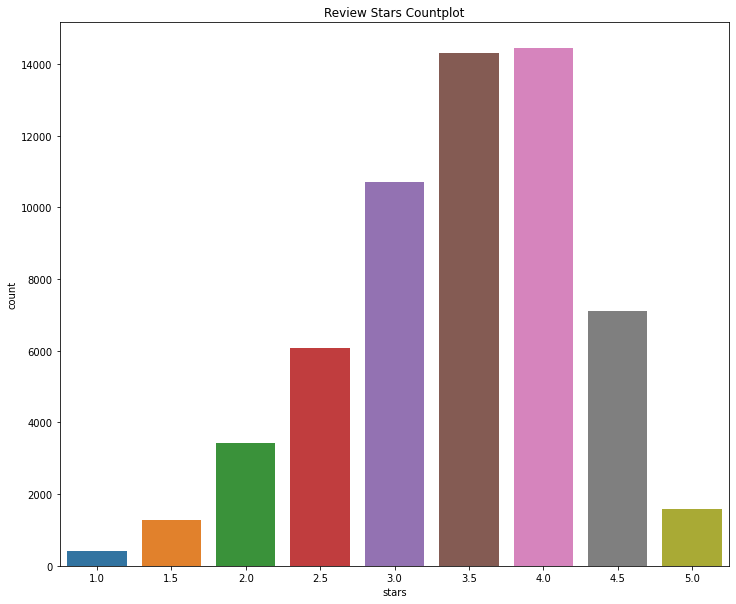

In [ ]:

fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(df_restaurants['stars'], ax=ax)
plt.title('Review Stars Countplot')
# plt.savefig('stars.png')
plt.show()

In [ ]:
top_restaurants = df_restaurants.sort_values(by=['review_count', 'stars'], ascending=False)[:20]
top_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants
82250,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,3655 Las Vegas Blvd S,Las Vegas,NV,89109,36.112859,-115.172434,4.0,8348,1,"{'Corkage': 'True', 'RestaurantsDelivery': 'Fa...","Food, French, Breakfast & Brunch, Restaurants,...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",True
89206,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,3570 S Las Vegas Blvd,Las Vegas,NV,89109,36.116113,-115.176222,4.0,8339,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Buffets, Sandwiches, Food, Breakf...","{'Monday': '7:30-22:0', 'Tuesday': '7:30-22:0'...",True
35199,K7lWdNUhCbcnEvI0NhGewg,Wicked Spoon,3708 Las Vegas Blvd S,Las Vegas,NV,89109,36.109550,-115.176155,3.5,6708,1,"{'GoodForKids': 'True', 'RestaurantsPriceRange...","Buffets, Breakfast & Brunch, Restaurants","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...",True
58852,f4x1YBxkLrZg652xt2KR5g,Hash House A Go Go,3535 Las Vegas Blvd,Las Vegas,NV,89109,36.118181,-115.171580,4.0,5763,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Breakfast & Brunch, Food, Restaurants, America...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",True
141820,cYwJA2A6I12KNkm2rtXd5g,Gordon Ramsay BurGR,3667 Las Vegas Blvd S,Las Vegas,NV,89109,36.110724,-115.172169,4.0,5484,0,"{'RestaurantsGoodForGroups': 'True', 'Alcohol'...","Restaurants, Burgers, American (Traditional)","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",True


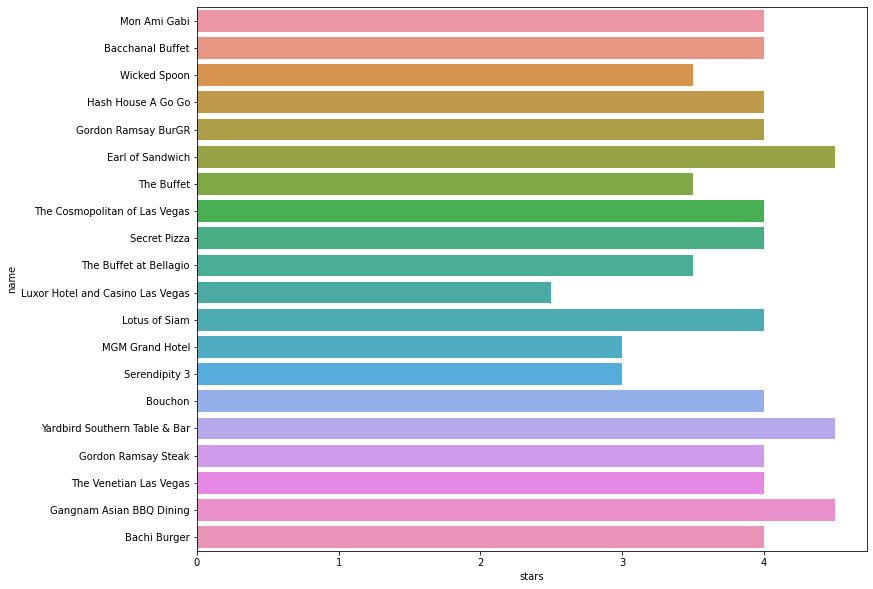

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x = 'stars', y = 'name', data=top_restaurants, ax= ax);
plt.savefig('top20_restaurants.png')
plt.show()

In [ ]:
px.set_mapbox_access_token("pk.eyJ1Ijoic2lkZHAyNzQiLCJhIjoiY2txZHM2bjdyMDd6bjJvbWxkcG5odW5zNCJ9.SZll1uNjsTQ-IdGd1n7zCw")
#configure_plotly_browser_state()
px.scatter_mapbox(df_restaurants, lat="latitude", lon="longitude", color="stars", size='review_count' ,
                   size_max=30, zoom=3, width=1200, height=800)

In [ ]:
lasVegas = df_restaurants[df_restaurants.state == 'NV']
px.scatter_mapbox(lasVegas, lat="latitude", lon="longitude", color="stars", size='review_count' ,
                   size_max=15, zoom=10, width=1200, height=800)

## K-Means Clustering

### Determing the number of clusters (K)

In [ ]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = lasVegas[['longitude','latitude']]

distortions = []
K = range(1,25)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)



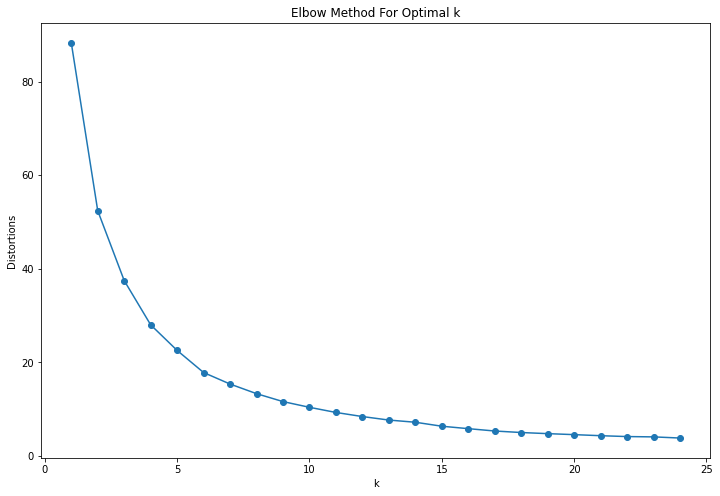

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
# plt.savefig('elbow.png')
plt.show()

Silhoute method


In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 50

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

In [ ]:
sil

[0.38400973051084614,
 0.3677901752872605,
 0.39636153321678325,
 0.3888088233098051,
 0.4089980230330813,
 0.41614369729120537,
 0.42500641839849623,
 0.4050806693455717,
 0.40744022438915106,
 0.4212430836616295,
 0.42878392708640933,
 0.4245598288368624,
 0.4343793984251435,
 0.4355191931263824,
 0.438650205371874,
 0.4417874687556212,
 0.4444111828621254,
 0.4334905853161627,
 0.4337639344392162,
 0.44477244262455834,
 0.42357099027042516,
 0.44553936068882516,
 0.4360440010350265,
 0.4263758483653204,
 0.4407686601579811,
 0.44675629666186123,
 0.4391872085003999,
 0.421558369411158,
 0.439488131121658,
 0.4257380888922858,
 0.44549098136995924,
 0.41701800707614284,
 0.4408584009464615,
 0.43491860263873783,
 0.4399030342638816,
 0.43226429730692884,
 0.4545544407740367,
 0.43622919010763367,
 0.4412086857565783,
 0.4404280799169692,
 0.45131967996131367,
 0.4497376897987731,
 0.44560551898022305,
 0.4444156802787925,
 0.45627169883766,
 0.4506697993585963,
 0.45573829722029696,


### K-Means Clustering

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(coords)
y = kmeans.labels_
print("k = 5", " silhouette_score ", silhouette_score(coords, y, metric='euclidean'))

k = 5  silhouette_score  0.38894535926295215


In [ ]:
lasVegas['cluster'] = kmeans.predict(lasVegas[['longitude','latitude']])
lasVegas.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants,cluster
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128529,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Italian",None,True,2
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5,184,1,"{'BikeParking': 'True', 'BusinessParking': '{'...","Mexican, Restaurants, Patisserie/Cake Shop, Fo...","{'Monday': '11:0-21:0', 'Tuesday': '10:0-21:0'...",True,4
75,kANF0dbeoW34s2vwh6Umfw,Dairy Queen,6125 Spring Mountain Rd,Las Vegas,NV,89146,36.125031,-115.225620,2.0,33,0,"{'RestaurantsPriceRange2': '1', 'Ambience': '{...","Fast Food, Food, Restaurants, Ice Cream & Froz...",None,True,2
111,X8mtoSxY8whtmbDlj0D3Aw,Imperial Asian Buffet,4343 N Rancho Dr,Las Vegas,NV,89030,36.238596,-115.233331,2.0,4,1,None,"Restaurants, Chinese",None,True,3
135,bJP4l_BGq2CudEu0m-wNjg,Artisan Fine Dining Room,"Artisan Hotel, 1501 W Sahara Ave",Las Vegas,NV,89102,36.143672,-115.169792,2.0,3,0,"{'RestaurantsAttire': ''dressy'', 'Corkage': '...","Restaurants, Pizza, Italian, American (New)","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",True,2


In [ ]:
px.scatter_mapbox(lasVegas, lat="latitude", lon="longitude", color="cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1200, height=800)

## Location-Based Recommendation

In [ ]:
top_restaurants_lasVegas = lasVegas.sort_values(by=['review_count', 'stars'], ascending=False)
top_restaurants_lasVegas.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Restaurants,cluster
82250,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,3655 Las Vegas Blvd S,Las Vegas,NV,89109,36.112859,-115.172434,4.0,8348,1,"{'Corkage': 'True', 'RestaurantsDelivery': 'Fa...","Food, French, Breakfast & Brunch, Restaurants,...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",True,2
89206,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,3570 S Las Vegas Blvd,Las Vegas,NV,89109,36.116113,-115.176222,4.0,8339,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Buffets, Sandwiches, Food, Breakf...","{'Monday': '7:30-22:0', 'Tuesday': '7:30-22:0'...",True,2
35199,K7lWdNUhCbcnEvI0NhGewg,Wicked Spoon,3708 Las Vegas Blvd S,Las Vegas,NV,89109,36.109550,-115.176155,3.5,6708,1,"{'GoodForKids': 'True', 'RestaurantsPriceRange...","Buffets, Breakfast & Brunch, Restaurants","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...",True,2
58852,f4x1YBxkLrZg652xt2KR5g,Hash House A Go Go,3535 Las Vegas Blvd,Las Vegas,NV,89109,36.118181,-115.171580,4.0,5763,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Breakfast & Brunch, Food, Restaurants, America...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",True,2
141820,cYwJA2A6I12KNkm2rtXd5g,Gordon Ramsay BurGR,3667 Las Vegas Blvd S,Las Vegas,NV,89109,36.110724,-115.172169,4.0,5484,0,"{'RestaurantsGoodForGroups': 'True', 'Alcohol'...","Restaurants, Burgers, American (Traditional)","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",True,2


In [ ]:
def recommend_restaurants(df, longitude, latitude):
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)
   
    # Get the best restaurant in this cluster
    return  df[df['cluster']==cluster].iloc[0:5][['name', 'latitude','longitude'	]]
   

In [ ]:
recommend_restaurants(top_restaurants_lasVegas,-115.1891691,  36.1017316)

2


,name,latitude,longitude
82250,Mon Ami Gabi,36.112859,-115.172434
89206,Bacchanal Buffet,36.116113,-115.176222
35199,Wicked Spoon,36.109550,-115.176155
58852,Hash House A Go Go,36.118181,-115.171580
141820,Gordon Ramsay BurGR,36.110724,-115.172169


In [ ]:
recommend_restaurants(top_restaurants_lasVegas,-115.2798544, 36.0842838) 

0


,name,latitude,longitude
131069,Hash House A Go Go,36.144713,-115.240092
116890,Echo & Rig,36.166576,-115.286232
42288,Red Rock Casino Resort & Spa,36.156413,-115.332847
11169,Juan's Flaming Fajitas & Cantina,36.100509,-115.302689
9191,Honey Salt,36.160577,-115.292996


In [ ]:
recommend_restaurants(top_restaurants_lasVegas, 	-115.082821, 36.155011 )

4


,name,latitude,longitude
111864,Lotus of Siam,36.143664,-115.141891
79764,Eat.,36.166900,-115.138977
127088,Pizza Rock,36.171618,-115.142267
55675,Carson Kitchen,36.167878,-115.140640
160676,Golden Nugget,36.169781,-115.145534


In [ ]:
test_coordinates = {
    'user': [1, 2, 3], 
    'latitude' : [36.1017316, 36.0842838, 36.155011],
    'longitude' : [-115.1891691, -115.2798544, -115.082821],
}

test_df = pd.DataFrame(test_coordinates)
test_df

,user,latitude,longitude
0,1,36.101732,-115.189169
1,2,36.084284,-115.279854
2,3,36.155011,-115.082821


In [ ]:
user1 = test_df[test_df['user'] == 1]
user1

,user,latitude,longitude
0,1,36.101732,-115.189169


In [ ]:
fig = px.scatter_mapbox(recommend_restaurants(top_restaurants_lasVegas, user1.longitude, user1.latitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1200, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user1["latitude"], lon= user1["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))

2


In [ ]:
user2 = test_df[test_df['user'] == 2].reset_index()
fig = px.scatter_mapbox(recommend_restaurants(top_restaurants_lasVegas, user2.longitude, user2.latitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1200, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user2["latitude"], lon= user2["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))

0


In [ ]:
user3 = test_df[test_df['user'] == 2].reset_index()
fig = px.scatter_mapbox(recommend_restaurants(top_restaurants_lasVegas, user3.longitude, user3.latitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1200, height=800, hover_data= ['name', 'latitude', 'longitude'])
fig.add_scattermapbox(lat=user3["latitude"], lon= user3["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))

0
